In [1]:
#### Please cite [.]: Van A. Ngo, Yen Ting Lin, Danny Perez. 
#### "Improving Estimatioon of Koopman Operators with Kolmogorov-Smirnov Indicator functions." 
#### Copyright: ORNL, LANL.

In [1]:
import numpy as np
import scipy
import scipy.linalg
import scipy.optimize
import scipy.stats
import math
import mdtraj as md
from glob import glob
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import random
import itertools
import sys
import pandas as pd
from importlib import reload
from sklearn import preprocessing
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import pyemma
import pyemma.coordinates as coor
from matplotlib import rcParams
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/vanngo/Research/miniconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
#!ls
sys.path.append('../KS')
from KSClustering import *

In [5]:
print(compute_timescale_(29,175),compute_timescale_(18,5),compute_timescale_(14,3))
print(compute_timescale_0(29,175),compute_timescale_0(18,5),compute_timescale_0(14,3))
print(compute_timescale_0(23,199),compute_timescale_0(15,5),compute_timescale_0(17,4))

24.37403213712782 3.3884860153528864 1.9275481177542633
24.877450980392158 3.9130434782608696 2.4705882352941178
20.617117117117118 3.75 3.238095238095238


In [7]:
pro='NTL9'
#pro='1FME'
#pro='2JOF'

In [11]:
skip=10
dt=skip*2/10000; # microseconds; 2 ns/step
print(dt*1000,'nanosecond')
lag=100; # # See a figure at the end; it's ok to use this value
#See the supporting information of Lindorff-Larsen et al. "How Fast Folding Proteins fold" for comparable data (RMSD)
print(lag*dt*1000,'nanosecond')

2.0 nanosecond
200.0 nanosecond


In [9]:
#load data from pickle
tg=pd.read_pickle(pro+'_RMSD.pkl')
rmsd=tg['rmsd']

In [ ]:
# this step can be ignored if you don't have dcd files; panda pickles of RMSD and Torsional angles are provided
CA=t.topology.select('name CA')
print('CA indices',CA)
t.superpose(t,frame=1000,atom_indices=CA,ref_atom_indices=CA)
rmsd=md.rmsd(t,t,frame=1000,atom_indices=CA)


In [ ]:
import pandas as pd
df =pd.DataFrame(data=rmsd,columns=['rmsd'])
df.to_pickle(pro+'_RMSD.pkl')

In [10]:
ndata=int(len(rmsd))
print('lag time is',lag*dt*1000,'nanoseconds')
for block in range(2100,2200,200):
    KS=KS_measure(rmsd[:ndata],block=block)
    KS_clustering=clustering2(KS,k=2,block=block)
    l=len(KS_clustering.cluster_KS_surrogate[0])
    data=[rmsd[:l]]
    data.append(KS_clustering.cluster_KS_surrogate)
    data=np.vstack(data)
    data=data.T
    vamp_orig=coor.vamp(data[:,0],dim=1,lag=lag)
    vamp_withsur2=coor.vamp(data,lag=lag)
    
    singular_orig=vamp_orig.singular_values
    singular_withsur2=vamp_withsur2.singular_values         
    
    print(block*dt,-dt*lag/log(np.absolute(singular_withsur2[0])),-dt*lag/log(np.absolute(singular_orig[0])),'$\mu s$')

lag time is 200.0 nanoseconds
using block = 2100
Using number of  2 clusters
indicator function  0
indicator function  1
4.2 22.558886826280958 0.24858801111692694 $\mu s$


(2, 554400)
found  5  transition events
transition times (199.08, 22.68)
found  5  transition events
transition times (22.68, 199.08)


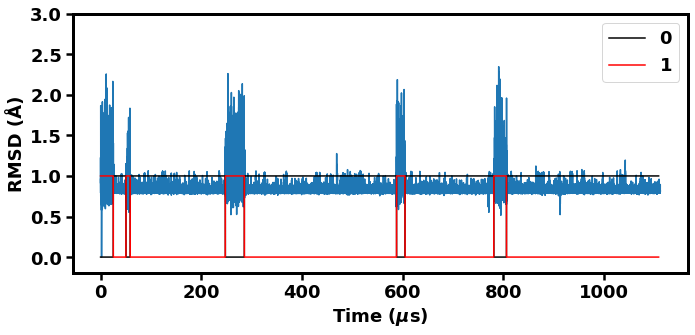

In [11]:
rcParams['axes.linewidth'] = 3
rcParams['xtick.major.width']=2.5
rcParams['ytick.major.width']=2.5
rcParams['xtick.major.size']=7
rcParams['ytick.major.size']=7
plt.rc('font',size=18,weight='bold')
majorLocator = MultipleLocator(50)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(25)
fig,ax=plt.subplots(1,1,figsize=(10,5))
ax.set_xlabel(r'Time ($\mu$s)',weight='bold')
ax.set_ylabel('RMSD (Å)',weight='bold')
time=np.arange(len(rmsd))*dt
ax.plot(time,rmsd)
print(np.shape(KS_clustering.cluster_KS_surrogate))
colors=['black','red','orange','green','green']
count=0

for tg in KS_clustering.cluster_KS_surrogate:
    time=np.arange(len(tg))*dt
    ax.plot(time,tg,label=str(count),color=colors[count])
    print('transition times',compute_transition(tg,dt=dt))
    count+=1
plt.legend()
ax.set_ylim(-0.2,3)
#ax.set_xlim(0,500000)
plt.tight_layout()
plt.savefig('RMSD_'+pro+'_data_block'+str(block)+'.png',dpi=300,bbox_inches='tight')
plt.show()
# this corresponds to the first trajectory (upper panel in Lindorff-Larsen et al, "How Fast-folding proteins fold")

In [ ]:
# try torsional angles:
# this step can be ignored if you don't have dcd files; panda pickles of RMSD and Torsional angles are provided
import math
phic=md.compute_phi(t)[1]
psic=md.compute_psi(t)[1]
chi1=md.compute_chi1(t)[1]
chi2=md.compute_chi2(t)[1]
chi3=md.compute_chi3(t)[1]
chi4=md.compute_chi4(t)[1]
chi5=md.compute_omega(t)[1]

In [8]:
#load data from pickle
features=pd.read_pickle(pro+'_torsional.pkl').to_numpy()
print(np.shape(features))

(556083, 190)


In [7]:
# this step can be ignored if you don't have dcd files; panda pickles of RMSD and Torsional angles are provided
features=np.hstack((np.cos(phic),np.cos(psic),np.cos(chi1),np.cos(chi2),np.cos(chi3),np.cos(chi4),np.cos(chi5)))
print(np.shape(features))

NameError: name 'phic' is not defined

In [9]:
#save features
df =pd.DataFrame(data=features)
df.to_pickle(pro+'_torsional.pkl')

In [12]:
data2=features
vamp_torsional=coor.vamp(data2[:,:],dim=5,lag=lag)

In [13]:
print(vamp_torsional.score())
# timescale.

timescale_torsional=-dt*lag/log(np.absolute(vamp_torsional.singular_values[0]))
print('timescale of the original data using the first five components is ',timescale_torsional)


2.2154916281928774
timescale of the original data using the first five components is  3.02727800593736


# Do KS via global matrix

In [ ]:
maxdim=10
block=2100
print('perform the analysis for dim = %f and lag = %f us with block = %f ' % (maxdim,lag*dt,block))
vamp_org=coor.vamp(data2[:,:],dim=maxdim,lag=lag)
project_vamp_org=vamp_org.get_output()
timescale_nind=[] 
for dim in range(1,maxdim+1):
    global_matrix=compute_global_matrix(project_vamp_org,dim=dim,block=block)
    data_with5global_clustering2 = Add_indicatorF(global_matrix,project_vamp_org,dim=dim,block=block,dt=dt)
    vamp_with5global_clustering2 = coor.vamp(data_with5global_clustering2,dim=dim,lag=lag)
    print('dim=',dim,'vampscore=',vamp_with5global_clustering2.score())
    timescale_with5global_clustering2=-dt*lag/log(np.absolute(vamp_with5global_clustering2.singular_values[0]))
    print('timescale of the original data is ',timescale_torsional, 'vs --',timescale_with5global_clustering2) 
    timescale_nind.append(timescale_with5global_clustering2)

perform the analysis for dim = 10.000000 and lag = 0.200000 us with block = 2100.000000 
using block = 2100
(264, 264)
Using number of  1 clusters
indicator function  0
ERROR: input is not indicator function
transition times (0, 0)
(554400, 11) should be (Trajectory_length, dimension)
dim= 1 vampscore= 1.875982779940256
timescale of the original data is  3.02727800593736 vs -- 3.020946202333785
using block = 2100
using block = 2100
(264, 264)
Using number of  2 clusters
indicator function  0
indicator function  1
found  5  transition events
transition times (199.08, 22.68)
found  5  transition events
transition times (22.68, 199.08)
(554400, 12) should be (Trajectory_length, dimension)
dim= 2 vampscore= 2.2368287358816517
timescale of the original data is  3.02727800593736 vs -- 24.89402187860821
using block = 2100
using block = 2100
using block = 2100
(264, 264)
Using number of  3 clusters
indicator function  0
indicator function  1
indicator function  2
found  3  transition events
tr

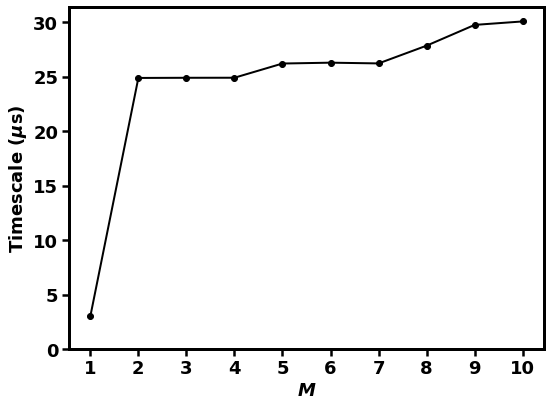

In [19]:
rcParams['axes.linewidth'] = 3
rcParams['xtick.major.width']=2.5
rcParams['ytick.major.width']=2.5
rcParams['xtick.major.size']=7
rcParams['ytick.major.size']=7
plt.rc('font',size=18,weight='bold')
majorLocator = MultipleLocator(50)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(25)
fig,ax=plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,11),timescale_nind,marker='o',linewidth=2,color='black')
ax.set_xlabel(r'$M$',weight='bold')
ax.set_ylabel(r'Timescale ($\mu$s)',weight='bold')
ax.set_yticks(np.arange(0,31,5))
ax.set_xticks(np.arange(1,11,1))
plt.tight_layout()
plt.savefig(pro+'_timescale_vs_number_components.png',bbox_inches='tight',dpi=300)

using block = 2100
using block = 2100
(264, 264)
Using number of  2 clusters
indicator function  0
indicator function  1
found  5  transition events
transition times (199.08, 22.68)
found  5  transition events
transition times (22.68, 199.08)
(554400, 12) should be (Trajectory_length, dimension)


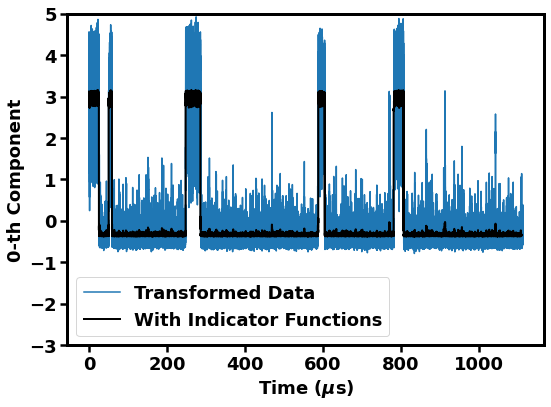

In [20]:
# plot the first component (included the indicator function) only
dim=2
vamp_org=coor.vamp(data2[:,:],dim=maxdim,lag=lag)
project_vamp_org=vamp_org.get_output()
global_matrix=compute_global_matrix(project_vamp_org,dim=dim,block=block)

data_with5global_clustering2 = Add_indicatorF(global_matrix,project_vamp_org,dim=dim,block=block,dt=dt)
vamp_with5global_clustering2 = coor.vamp(data_with5global_clustering2,dim=dim,lag=lag)
project_vamp_with5comp2=vamp_with5global_clustering2.get_output()

rcParams['axes.linewidth'] = 3
rcParams['xtick.major.width']=2.5
rcParams['ytick.major.width']=2.5
rcParams['xtick.major.size']=7
rcParams['ytick.major.size']=7
plt.rc('font',size=18,weight='bold')
majorLocator = MultipleLocator(50)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(25)
fig,ax=plt.subplots(1,1,figsize=(8,6),sharex=True)
t1=np.arange(len(np.vstack(project_vamp_org)[:,0]))*dt

t2=np.arange(len(np.vstack(project_vamp_with5comp2)[:,0]))*dt
for i in range(1):
    
    #if i ==0:
    #ax.plot(rmsd,label='RMSD')
    ax.plot(t1,np.vstack(project_vamp_org)[:,i],label='Transformed Data')
    #ax[ix][iy].plot(t2,-np.vstack(project_vamp_withsur)[:,i],label='With Indicator Functions',color='red',linewidth=2)
    ax.plot(t2,-np.vstack(project_vamp_with5comp2)[:,i],label='With Indicator Functions',color='black',linewidth=2)
    # the minus sign does not matter
    #ax.plot(KS_clustering.cluster_KS_surrogate,label='RMSD Surrogate',color='black',linewidth=1.5)
    ax.set_ylabel(str(i)+'-th Component',weight='bold')
    
    ax.set_xlabel(r'Time ($\mu$s)',weight='bold')
plt.legend(loc='best')
ax.set_ylim(-3,5)
plt.tight_layout()
plt.savefig(pro+'torsional_comparison_Comp'+str(i)+'k12_with5comp2.png',dpi=300,bbox_inches='tight')
    
plt.show()

In [ ]:
# testing the timescale with different lagtime for the use of only first component (dim=2)
dim=2
block=2100
timescale_vs_lag=[] 
for lag in range(10,400,10):
    vamp_org=coor.vamp(data2[:,:],dim=maxdim,lag=lag)
    project_vamp_org=vamp_org.get_output()
    global_matrix=compute_global_matrix(project_vamp_org,dim=dim,block=block); 
    data_with5global_clustering2 = Add_indicatorF(global_matrix,project_vamp_org,dim=dim,block=block,dt=dt); 
    vamp_with5global_clustering2=coor.vamp(data_with5global_clustering2,dim=dim,lag=lag)
    print('lag=',lag,'vampscore=',vamp_with5global_clustering2.score())
    timescale_with5global_clustering2=-dt*lag/log(np.absolute(vamp_with5global_clustering2.singular_values[0]))
    print('timescale of the original data is ',timescale_torsional*dt, 'vs --',timescale_with5global_clustering2) 
    timescale_vs_lag.append(timescale_with5global_clustering2)

In [ ]:
plt.ylim(0,30)
plt.ylabel('Timescale ($\mu$ s)',weight='bold')
plt.xlabel('Lagtime (ns)',weight='bold')
plt.plot(np.arange(10,400,10)*dt*1000,timescale_vs_lag,color='black',marker='o')